### Preparation of Project
Import necessary libraries for this language project.

In [1]:
import torch
import torch.nn as nn
from torch.nn import functional as F

from transformers import LlamaTokenizer

import matplotlib.pyplot as plt
import numpy as np

Configure parameters and settings for the model.
- `batch_size`: the batch size to 100, which means that 100 samples will be processed together in each iteration of training
- `block_size`: the size of a block of data processing units
- `max_iters`: the maximum number of iterations the training process should run
- `eval_intervals`: the evaluation interval, meaning the model will be evaluated every 500 iterations
- `learning_rate`: the learning rate for the optimizer
- `eval_iters`: the amount of iterations used in the loss function
- `n_embd`, `n_head`, `n_layer`: number of embedding dimensions, number of attention heads, number of layers

In [2]:
batch_size = 64
block_size = 256
max_iters = 5000
eval_interval = 500
learning_rate = 4e-5
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2
torch.manual_seed(1337)

Create datesets

The training dataset is downloaded at "`${path to the project}/P3/data`"(https://www.kaggle.com/datasets/thedevastator/the-bards-best-a-character-modeling-dataset). Read the dataset from it and encode it into `torch.long` type using Llama2 tokennizer.

In [3]:
# Dataset
with open('./data/train.csv', 'r', encoding='UTF-8') as f:
    train_text = f.read()

with open('./data/test.csv', 'r', encoding='UTF-8') as f:
    test_text = f.read()

with open('./data/validation.csv', 'r', encoding='UTF-8') as f:
    val_text = f.read()


Using tokenizer of Llama2(please download your Llama2 pretrained model to "`${path to the project}/P3/ckpts`")

In [4]:
# Tokenizer
tokenizer = LlamaTokenizer.from_pretrained('./ckpts/Llama2-7b-hf/')
# chars = sorted(list(set(train_text + test_text + val_text)))
# vocab_size = len(chars)
vocab_size = tokenizer.vocab_size

encode = lambda s: tokenizer.encode(s, add_special_tokens=False) # Encoder
decode = lambda l: tokenizer.decode(l, add_special_tokens=False) # Decoder

Encode data

In [5]:
train_data = torch.tensor(encode(train_text), dtype=torch.long)
val_data = torch.tensor(encode(val_text), dtype=torch.long)

### Self Attention

Class `Head` is a self-attention head. This code essentially defines a module that performs self-attention operation in the transformer architecture.

In [6]:
class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)   # (B,T,hs)
        q = self.query(x) # (B,T,hs)
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out

Class `MultiHeadAttention` defines the code of multiple heads in parallel.

In [7]:
class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        # Added the possibility to add heads per parameter and loop. That's it.
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

### Feed Forward
This module essentially performs a feedforward operation with a neural network that has two hidden layers and includes a dropout layer. It’s a feedforward architecture used in neural networks.

In [8]:
class FeedFoward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)

### Block
A transformer block that first allows communcation between tokens and then computation

In [9]:
class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedFoward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

### Language Model
This language model combines token embedding, positional embedding, and multiple Transformer modules.

In [10]:
class LanguageModel(nn.Module):

    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        # Added the possibility to add heads per parameter and loop. That's it.
        self.blocks = nn.Sequential(*[Block(n_embd, n_head=n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        if targets is None:
            loss = None
        else:
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        for _ in range(max_new_tokens):
            idx_cond = idx[:, -block_size:]
            logits, loss = self(idx_cond)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            idx_next = torch.multinomial(probs, num_samples=1) # (B, 1)
            idx = torch.cat((idx, idx_next), dim=1) # (B, T+1)
        return idx

Create the language model and output its parameters. 

In [11]:
model = LanguageModel()
m = model.to(device)
# print the number of parameters in the model
print(sum(p.numel() for p in m.parameters())/1e6, 'M parameters')

35.346944 M parameters


### Data Loading

Load a data batch for training for any split(train or validation)

In [12]:
def get_batch(split):
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x, y = x.to(device), y.to(device)
    return x, y

### Losss Estimate
Estimate the loss of a machine learning model for both training and validation datasets. It's much more sincere to look at multiple batches of predictions, calculate each loss and average them out

In [13]:
# Loss
@torch.no_grad()
def estimate_loss():
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out


### Expriment
Optimizer the model.

In [14]:
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

train_losses = []
val_losses = []

for iter in range(max_iters):

    # every once in a while evaluate the loss on train and val sets
    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")
        train_losses.append(losses['train'].item())
        val_losses.append(losses['val'].item())

    # sample a batch of data
    xb, yb = get_batch('train')

    # evaluate the loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

step 0: train loss 10.5453, val loss 10.5654
step 500: train loss 5.4757, val loss 5.6066
step 1000: train loss 4.7350, val loss 5.0214
step 1500: train loss 4.3967, val loss 4.7420
step 2000: train loss 4.1722, val loss 4.5712
step 2500: train loss 3.9917, val loss 4.4723
step 3000: train loss 3.8334, val loss 4.3799
step 3500: train loss 3.6946, val loss 4.2943
step 4000: train loss 3.5621, val loss 4.2346
step 4500: train loss 3.4434, val loss 4.1792
step 4999: train loss 3.3480, val loss 4.1643


Draw the loss curve during the training progress.

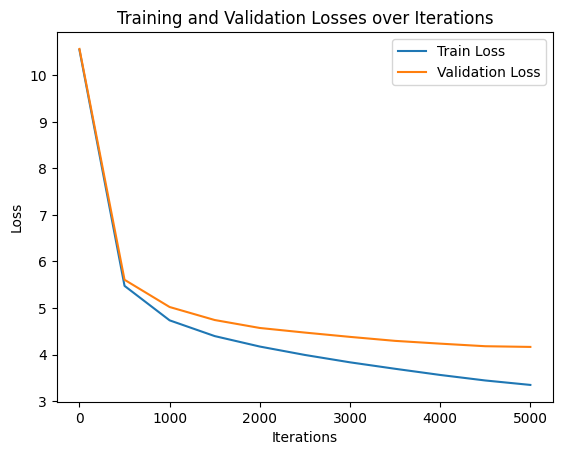

In [15]:
iterations = np.arange(0, max_iters+1, eval_interval)
plt.plot(iterations, train_losses, label='Train Loss')
plt.plot(iterations, val_losses, label='Validation Loss')
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.title('Training and Validation Losses over Iterations')
plt.legend()
plt.show()

Generate some sentences.

In [16]:
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(m.generate(context, max_new_tokens=1000)[0].tolist()))

<unk> ; shall die and the English crown,
Briek-cour. Let me well:
Hence to our skot.

FRIAR LAURENVOLIO:
Thus, noble sudden!
Why, let it call them be my tro grandamous heaven
And our marriage too muchced me twain's eyes,
Which, f foot lance; and sweet sir,
Or pay thine or we will inform hath help at our lady'd:
'd
If we have any reign, brats, to woul fight against his life,
In fool depends be impeaceides no cause
With very perhaps.

FENVOLIO:
But are as wonderful, 'Sitting woo's call'd.

Thou art body? why I have done so pass me not?

BENVOLIO:
O, truly bawd not, God,
I have to the enrich end, two dangerControlsful king,
As felt Henry you have made us,
Can steeds.
Volsce will live within again to the English a crushion of
agems
Of a true service, if none be revengeance, unless:
Make itingsområ by.

Both give my cousin I am to see me sound:
If I revenge!
What, speaking now with you cannot choose woo your gaol hardly
The king
Though Edward bleble nurse toaze, and leave and dissests,
Even